In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 19

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 19)                209       
                                                                 
Total params: 1279 (5.00 KB)
Trainable params: 1279 (5.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


71/94 [=====================>........] - ETA: 0s - loss: 2.9170 - accuracy: 0.0743
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 2s 5ms/step - loss: 2.8957 - accuracy: 0.0888 - val_loss: 2.7581 - val_accuracy: 0.1732
Epoch 2/1000
74/94 [======================>.......] - ETA: 0s - loss: 2.7049 - accuracy: 0.1554

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 2.6857 - accuracy: 0.1590 - val_loss: 2.4625 - val_accuracy: 0.2110
Epoch 3/1000
76/94 [=======================>......] - ETA: 0s - loss: 2.4789 - accuracy: 0.2225
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 2.4494 - accuracy: 0.2350 - val_loss: 2.1920 - val_accuracy: 0.3573
Epoch 4/1000
74/94 [======================>.......] - ETA: 0s - loss: 2.2533 - accuracy: 0.2978
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [==============================] - 0s 3ms/step - loss: 2.2405 - accuracy: 0.2995 - val_loss: 1.9610 - val_accuracy: 0.4106
Epoch 5/1000
91/94 [============================>.] - ETA: 0s - loss: 2.0998 - accuracy: 0.3327
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
94/94 [=============

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

32/32 [==============================] - 0s 2ms/step - loss: 0.6607 - accuracy: 0.8293


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 114ms/step
[4.69880663e-02 1.68254133e-03 2.23235766e-04 3.58926039e-03
 5.81869297e-02 1.24126353e-04 2.01031999e-05 3.56693295e-06
 9.14661773e-03 3.34555702e-03 1.48689705e-05 4.32398468e-01
 2.85326272e-01 7.08803441e-03 4.89769043e-08 1.26581117e-05
 5.15772917e-05 1.51748464e-01 4.95587446e-05]
11


# 混同行列

125/125 [==============================] - 0s 1ms/step


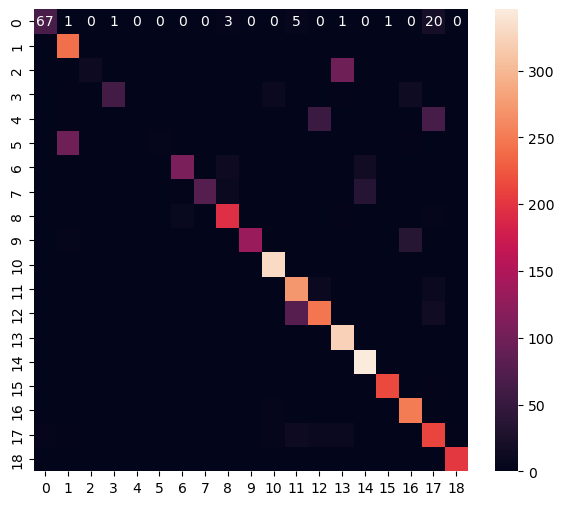

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.68      0.79        99
           1       0.69      1.00      0.82       241
           2       1.00      0.10      0.19       107
           3       0.95      0.68      0.79        91
           4       0.00      0.00      0.00       121
           5       1.00      0.03      0.06       102
           6       0.91      0.80      0.85       134
           7       0.99      0.62      0.76       125
           8       0.88      0.93      0.90       210
           9       0.99      0.77      0.87       172
          10       0.95      0.99      0.97       333
          11       0.74      0.93      0.83       292
          12       0.77      0.72      0.75       343
          13       0.74      1.00      0.85       322
          14       0.87      1.00      0.93       347
          15       1.00      0.99      0.99       217
          16       0.83      0.98      0.90       257
     

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmp2_4bw06f\assets


INFO:tensorflow:Assets written to: C:\Users\tanta\AppData\Local\Temp\tmp2_4bw06f\assets


7204

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 3.99 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.69880588e-02 1.68253935e-03 2.23235606e-04 3.58925783e-03
 5.81869185e-02 1.24126149e-04 2.01032053e-05 3.56692703e-06
 9.14662238e-03 3.34556121e-03 1.48689305e-05 4.32398587e-01
 2.85326213e-01 7.08803209e-03 4.89769150e-08 1.26580780e-05
 5.15772554e-05 1.51748464e-01 4.95587592e-05]
11
